In [100]:
import pandas as pd
import numpy as np

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
sns.set(rc={'figure.figsize': (9, 6)})

[event_data_train](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами.

Описание данных:
1. **step_id** - id стэпа
2. **user_id** - анонимизированный id юзера
3. **timestamp** - время наступления события в формате unix date
4. **action** - событие, возможные значения:
    - _discovered_ - пользователь перешел на стэп
    - _viewed_ - просмотр шага
    - _started_attempt_ - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    - _passed_ - удачное решение практического шага


[submissions_train](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям.

Описание данных:
1. **step_id** - id стэпа
2. **timestamp** - время отправки решения в формате unix date
3. **submission_status** - статус решения
4. **user_id** - анонимизированный id юзера

In [103]:
events_data = pd.read_csv('../event_data_train.csv')

Ознакомимся с форматом данных

In [104]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


Поначалу видим, что мы имеем сырые данные. Обычно такие записи свойственны записям в БД, логи и т.д., где просто на каждое событие происходит простое её логирование.

Посмотрим подробнее на данные

In [105]:
events_data.action.nunique()

4

In [106]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Сперва переведём "timestamp" с unix-time в более читаемую дату. Чтобы в дальнейшим было удобно сортировать данные, например, по месяцам.  
Python имеет множество библиотек для работой с датой (datetime, calendar, ...), но воспользуемся встроенным методом pandas.

In [107]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [108]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


Также посмотрим на формат данных.

In [109]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

Также можно посмотреть теперь более подробно на базовые характеристики данных.

In [110]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [111]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [112]:
events_data['day'] = events_data.date.dt.date

In [113]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


Сгруппируем данные, чтобы посмотреть, сколько было уникальных пользователь за день.

In [114]:
events_data.groupby('day').user_id.nunique()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
             ... 
2018-05-15    145
2018-05-16    155
2018-05-17    165
2018-05-18    126
2018-05-19    131
Name: user_id, Length: 1070, dtype: int64

Для наглядности нарисуем график.

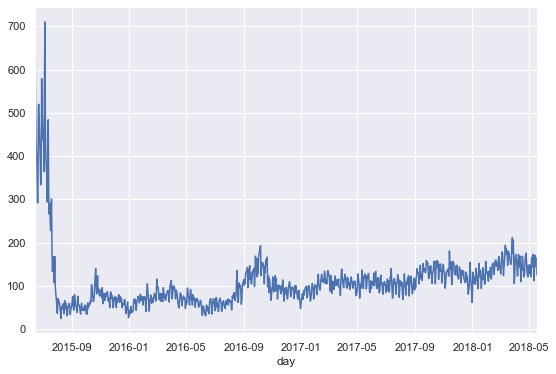

In [115]:
# events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))
events_data.groupby('day').user_id.nunique().plot()

Убедимся, что данные не повреждены, имеют целостную структуру и соответствуют описанной проблеме. Необходимо провести анализ первичных данных перед машинным обучением. Иначе - нужно устранить все артефакты в данных.

Теперь для каждого пользователя посчитаем число пройденных степов и посмотрим на распределение.

In [116]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


!!! НЕПРАВИЛЬНОЕ РЕШЕНИЕ !!!

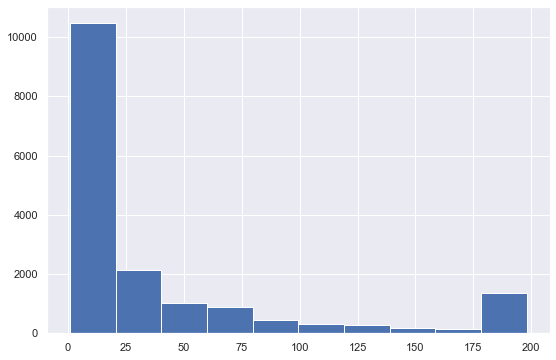

In [117]:
events_data[events_data.action == 'passed'].groupby('user_id', as_index=False).agg({'step_id': 'count'}).rename(columns={'step_id': 'passed_steps'}).passed_steps.hist() 

Но пользователи, у которых нет ни одного 'passed' стэпа вообще не попали в этот результат.

Подход, представленный выше, "схлопывает" наши наблюдения и не ответит на поставленный вопрос.

!!! ПРАВИЛЬНОЕ РЕШЕНИЕ !!!

Воспользуемся другой функцией, применяющейся для агрегации данных - pivot_table.

In [118]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                       fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


А ниже уже более честное распределение

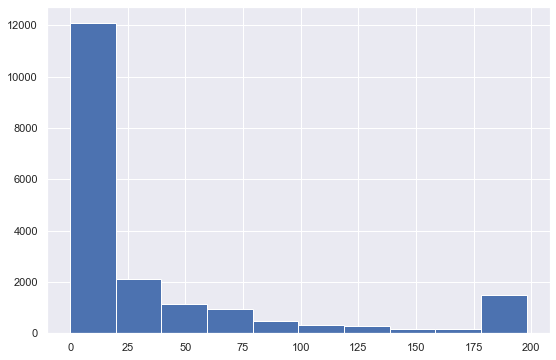

In [119]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                       fill_value=0).reset_index().discovered.hist()

In [120]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [121]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


Считаем ещё одну страницу.

In [88]:
submissions_data = pd.read_csv('../submissions_data_train.csv')

In [123]:
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [124]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit="s")
submissions_data['day'] = submissions_data.date.dt.date

In [125]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                       fill_value=0).reset_index()

In [126]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


Теперь необходимо сделать разделение между пользователями, которые решили просто сделать перерыва в прохождении курса, и пользователями "дропнувшимися".   
Определим пороговый промежуток. Посмотрим, как в среднем распределено время перерывов в прохождении курса между пользователями.

Оставим только нужные нам для анализа данные.

In [127]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


Соберём все timestamp's для каждого пользователя, в которые он был на курсе, и посмотрим перерывы между ними.

In [128]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

Теперь нужно посчитать временные промежутки между днями.

In [129]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')['timestamp'].apply(list).apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

Соберём всё в один массив.

In [130]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [131]:
np.concatenate(gap_data, axis=0)

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

In [132]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [133]:
gap_data = gap_data / (24 * 60 * 60) # разница в днях у пользователей

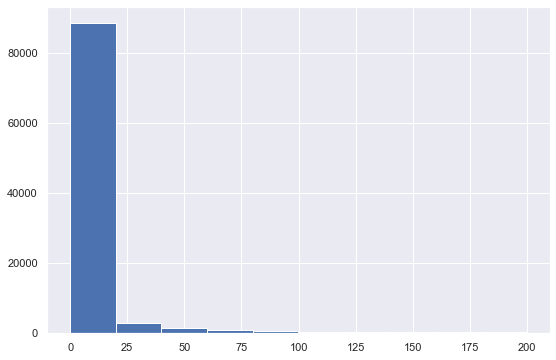

In [134]:
gap_data[gap_data < 200].hist()

In [135]:
gap_data.quantile(0.95)

59.760440972222156

Следовательно, только 5% пользователей возвращается на курс после перерыва в 2 месяца.

Возьмём перерыв в 30 дней. 

==========================================  
хакерская задача, за каким вымышленным id скрывается автор курса, данные которого мы анализируем?

In [389]:
hack_id = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                       fill_value=0)

In [391]:
hack_id[hack_id['correct'] == hack_id['correct'].max()]

submission_status,correct,wrong
user_id,,
1046,421,513


OR

In [392]:
events_data.groupby('user_id')['day'].nunique().idxmax()

1046

In [367]:
users_scores.sort_values(['correct'], ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


===========================================================

In [136]:
gap_data.quantile(0.90) / (24 * 60 * 60)

0.00021210642789780559

In [137]:
# посмотрим на финальный день
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Рассчитаем для каждого пользователя максимальное время появления на курсе.

In [138]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(
    columns={'timestamp': 'last_timestamp'}
)

Нас интересует, правда ли что этот максимальный "timestamp" больше, чем определённое нами пороговое значение.

In [139]:
# >> 30 * 24 * 60 * 60
# 2592000
now = 1526772811
dropout_threshold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > dropout_threshold

In [140]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Теперь нужно понять, правда ли отмеченные пользователи НЕ ПРОШЛИ курс.  
Примержим к этой табличке анные про число попыток (успешных и неуспешных) и число набранных баллов и посмотрим, что получается.  
Добавим данные про количество правильных и неправильыых решений.  
Воспользуемся методом merge для соединения таблиц по user_id.

In [141]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [142]:
users_data.merge(users_scores).head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,2,1519226966,True,2,0
1,3,1444581588,True,29,23
2,5,1499859939,True,2,2
3,8,1481466913,True,9,21
4,14,1436368676,True,0,1


Есть проблема - мы потеряли данные.

Что мы потеряли?

В users_score хранятся данные о попытках пользователя - correct и wrong. А что если пользователь вообще не отправлял данные?

Например, у пользователя 1 вообще нет попыток - ни правильных, ни неправильных. И в результате мерджа он пропал из результирующей таблицы выше.

Поэтому, когда мы делаем мердж или джойн нужно помнить, что когда мы мерджим по умолчанию скорее всего будет использован inner merge. То есть будут взяты только те пользователи, которые есть в каждом из датафреймов, то есть пересечение.

Это решается добавление аргумента how='outer'.

In [143]:
users_data.merge(users_scores, how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


Пользователь с user_id = 1 теперь попал в итоговую выдачу, что мы и ожидали.

Теперь при таком мердже получилось так, что записи, отсутствующие в одной из таблиц, всё равно будут в результирующей, но они будут заполнены NaN.

Это важно понимать и всегда нужно проверять себя на непротиворечивость в данных, чтобы мы никого нигде не потеряли.

Когда мы делаем мердж и не указываем ключ, по которому нужно делать мердж -> pandas автоматически ищет колонку с одинаковым названием. Можно указать ключ явно в качестве значения аргумента on.

In [144]:
users_data.merge(users_scores, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [145]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [146]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,NaN,NaN
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


Теперь избавимся от пустых значений в нашем результирующем датасете -> заменим их 0.

In [147]:
users_data = users_data.fillna(0)

In [148]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


Теперь прикрутим данные и про остальные события.

In [149]:
users_events_data = events_data.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count',
                                            fill_value=0).reset_index()

In [150]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Для каждого юзера у нас есть подсчёт его событий. Приджойним этот датасет к нашему ранее созданному смердженному датасету.

In [151]:
users_data = users_data.merge(users_events_data, how='outer')

In [152]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Сейчас в данной таблице есть вся интересующая информация о пользователе, кроме одной важной фичи - сколько уникальных дней пользователь был в сервисе.

Добавим эту статистику.

In [153]:
users_days = events_data.groupby('user_id').day.nunique()

In [154]:
users_days.head()

user_id
1    1
2    2
3    7
5    2
7    1
Name: day, dtype: int64

### Как перейти от пандасовской серии к датафрейму?

In [155]:
### series_name.to_frame().reset_index()
users_days = users_days.to_frame().reset_index()

In [156]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Давайте теперь домёрджим это к нашей табличке, в которой мы собираем информацию о наших пользователях.

In [157]:
users_data = users_data.merge(users_days, how='outer')

In [158]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем, что мы никого не потеряли, смотрим на количество юзеров.

In [159]:
users_data.user_id.nunique()

19234

А сколько юзеров в сырых данных

In [160]:
events_data.user_id.nunique()

19234

Хорошая практика - проверка себя на каждом этапе, что мы нигде не потеряли данные

Последняя колонка которую мы хотим добавить - показатель того, что пользователь успешно закончил курс.

Например, пользователь набрал более 175 пройденных шагов.

Тогда сделаем ещё одну колонку.

In [161]:
users_data['passed_course'] = users_data.passed > 170

In [162]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [163]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [164]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

Итак, возвращаемся к нашей практической задаче - предсказание оттоков пользователей со степика.

В первом модуле мы закончили довольно важный и при этом довольно понятный этап для любой задачи, возникающей в machine-learning, аналитике, data-mining и т.д. У нас просто были какие-то сырые данные, и мы привели их к более понятному виду. Мы их смёрджили, предобработали, агрегировали. Мы как минимум получили понятную историю в этих данных, посмотрели, что всё с этими данными всё хорошо и с ними можно работать.

На самом деле ещё даже до применения моделей (особенно когда речь идёт о продуктовой аналитике и у нас есть цель скажем, разобраться почему пользователи дропаются) уже какие-то гипотезы можно получить, просто посмотрев на такой промежуточный агрегат.

Допустим, уже сейчас можно изучить последние сессии дропнувшихся пользователей и убедиться в том, что один из таких частых сценариев - это когда человек натыкается на какую-то сложную задачу, очень долго подряд не может её решить и потом уже никогда к нашему курсу не возвращается.

Таким образом, некоторые интересные вещи ещё до моделирования, до обучения могут броситься в глаза.

Нужно переформулировать задачу на язык машинного обучения. Наша цель как можно раньше предсказать, что пользователь уйдёт с курса "Анализ данных в R" и давайте для начала решим первую версию задачи. Для этого ответим на опрос - "можем ли мы, анализируя поведения пользователя за первые N дней, предсказать тот факт, что пользователь пройдёт курс до конца или дропнется и не наберёт нужное количество баллов?".

=================================================================  
Чтобы не запутаться, заново укомпанованно загрузим необходимые данные и выполненные ранее наработки.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# reading datasets
events_data = pd.read_csv('../event_data_train.csv')
submissions_data = pd.read_csv('../submissions_data_train.csv')

In [2]:
# adding new columns
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

# calculating for each user count correct submimit
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 170

In [3]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [4]:
# Проверка, что данные не потеряны
users_data.user_id.nunique()

19234

In [5]:
events_data.user_id.nunique()

19234

==========================================================================

Из сырых логов и разных источников мы свели все данные воедино. И, в принципе, можно наполнить эту табличку ещё несколькими важными колонками, но сейчас основная идея этой таблички была в том, что у нас были сырые логи, а теперь есть датафрейм users_data, в котором про каждого пользователя мы знаем:
* его статус на текущий момент (правда ли, что он закончил курс успешно / дропнулся), + сколько он сделал попыток,
* когда его последний раз видели на курсе.

То есть пока ещё датафрейм, наверное, не очень применим для какого-то машинного обучения, хотя какие-то гипотезы можно уже и отсюда повытаскивать. Однако этот датафрейм нам точно потребуется ещё не раз, потому что, например, его можно использовать для разметки нашей выборки.

Теперь давайте подбираться к нашей первой задаче машинного обучения - попробуем, анализируя поведение пользователя за его первые несколько дней, после которых он начал курс, предсказать - правда ли, что он успешно закончит курсу или дропнется с него.

Для начала можно предположить, что мы можем использовать, скажем, первые 2-3 дня. Вообще, если бы мы решали эту задачу по-настоящему - это как раз тот пример, когда у нас нет готового правильного ответа на вопрос "сколько первых дней нам нужно, чтобы предсказать уйдёт пользователь с курса или нет?". Поэтому можно попробовать разные пороги, нащупать какой-то оптимальный баланс времени и качества. Понятное дело, что если мы будем использовать первые две недели, то мы слишком поздно будем реагировать. Если мы будем пытаться предсказывать поведение пользователя за первые два часа с момента его начала работы с курсом - это, конечно, здорово, но возможно мы потеряем в точности.

Поэтому нужно экспериментировать и давайте начнём, например, с 3-х дней. Для начала можно в принципе проверить насколько это адекватно, потому что у нас есть данные про то, сколько уникальных дней пользователь потратил на прохождение курса - колонка day. Можно посчитать медиану, предварительно отобрав только те наблюдения, у которых passed_course = True.

Обратите внимание, что это уже вектор True\False, поэтому можно просто передать его в качестве фильтра. Хотя это возможно не очень правильно, но так можно сделать.

добавим ещё одну колонку - когда пользователь первый раз появился на курсе.

In [6]:
users_data[users_data.passed_course].day.median()

20.0

Мы видим, что медиана у нас 20 дней. Если построить гистограмму, то мы увидим типично скошенную метрику.

In [7]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


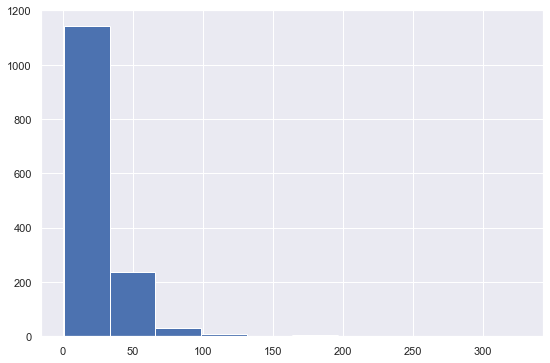

In [166]:
users_data[users_data.passed_course].day.hist()

Интересное наблюдение - большинство метрик, как-то характеризующих взаимодействие пользователя с продуктом, очень часто распределены не нормально. Скажем, процент лайков, репостов в соцсетях, количество дней, затраченных пользователями на прохождение курса, число решённых задач и т.д. Скорее всего это будет ненормальное распределение. Такие классические симметричные распределения на самом деле в реальной практике попадаются довольно редко.

Мы видим, что медиана 20, т.е. половина пользователей решает более 20 дней, поэтому 3 дня кажется адекватным порогом. Попробуем предсказать

Итак, наша первая задача: отобрать те наблюдения, которые мы будем использовать для обучения events_data, т.е. события, происходящие с пользователем в течение его первых трёх дней из общего датафрейма.

Сейчас здесь для каждого пользователя лежит вся его информация про все его действия на протяжении всей истории, доступной нам в этой выгрузке. Нужно для каждого юзера отобрать только его события, укладывающиеся в диапазон от его первого события плюс 3 дня.

Отберём данные о первых активных действиях пользователя на курсе:

In [8]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [9]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


Добавим эту информацию в исходный датафрейм:

In [10]:
users_data = users_data.merge(user_min_time, how='outer')

In [11]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Теперь у нас есть информация не только про то, когда пользователь впервые был на курсе, но и когда он завершил своё действие на курсе - какой у него был последний timestamp.

Довольно необычная задача - теперь нужно для данных, хранящихся в events_data, отобрать только наблюдения, проходящие по некоторому условию, а именно - у нас для каждого юзера есть некоторое его окно, в которое мы можем уместить нужные нам наблюдения, и их то и нужно отобрать.

Задача довольно интересная, потому что это такая нетривиальная фильтрация и решить её можно несколькими способами.

### "Неправильный" способ

In [12]:
event_data_train = pd.DataFrame() # сюда сложим уже отобранные данные

In [17]:
for user_id in users_data.user_id:
    min_user_time = users_data.loc[users_data.user_id == user_id, 'min_timestamp'][0]
    break

In [19]:
min_user_time

1472827464

In [20]:
user_id

1

In [21]:
users_data[['user_id', 'min_timestamp']].head(3)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476


Теперь сделаем нужную фильтрацию из исходного датафрейма

In [22]:
for user_id in users_data.user_id:
    min_user_time = users_data.loc[users_data.user_id == user_id, 'min_timestamp'][0]
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
    break

In [23]:
user_events_data

,step_id,timestamp,action,user_id,date,day
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1347417,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02


Мы получили датафрейм для первого юзера из событий в его первые 3 дня на курсе. Всё корректно отработало - убираем break из цикла и наращиваем наш итоговый датафрейм.

In [ ]:
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
#     user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
#     event_data_train.append(user_events_data)

Выполнение данного блока кода займёт очень длительное время. Причина в том, что такого рода операции над датафреймами очень затратные, поскольку выполняются: фильтрация, append не очень эффективен.

Такой код не pandas way.
Одной командой, одной маской сделать event_data_train, указав, что это event_data с некоторым условием:

event_data_train = events_data[]

In [26]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [27]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [28]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Мы сшили идентификатор пользователя со значениями времени.

Вынесем переменную порогового значения для timestamp, которую мы будем использовать далее:

In [29]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

Для каждого пользователя сделаем связку его идентификатора и максимального значения, которое можно использовать для того, чтобы продолжать работу.

У нас есть уже подготовленный user_min_time и давайте теперь сделаем заготовленную серию, в которой для каждого пользователя будут проставлены его максимальное значение времени и сам идентификатор пользователя, после которого мы уже не будем эти данные использовать.

In [30]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [31]:
user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

Вынесем результат этого вычисления в отдельную колонку. Можем, например, добавить в наш датафрейм, хранящий минильное время юзера. Это будет как раз минимум и максимум, который мы будем использовать для отсечения событий.

In [32]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [33]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [34]:
events_data.shape

(3480703, 8)

In [35]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Теперь для каждого пользователя достаточно просто узнать - "правда ли, что его время выполнения каждого действия вписыается в нужный нам диапазон?"

In [36]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [37]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [38]:
events_data_train.shape

(1014985, 8)

==============================================
Лирическое отступление

In [50]:
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [61]:
last_users_data = submissions_data \
    .groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={
                    'timestamp': 'last_timestamp'
                    })

In [62]:
last_users_data

,user_id,last_timestamp
0,2,1514383485
1,3,1444573728
2,5,1499859730
3,8,1480604143
4,14,1436368601
...,...,...
9935,26787,1469015051
9936,26790,1451722691
9937,26794,1511374868
9938,26797,1508425828


In [53]:
submissions_data = submissions_data \
    .merge(last_users_data[['user_id', 'last_timestamp']], how='outer')

In [54]:
submissions_data

,step_id,timestamp,submission_status,user_id,last_timestamp
0,31971,1434349275,correct,15853,1479734163
1,31972,1434348300,correct,15853,1479734163
2,31972,1478852149,wrong,15853,1479734163
3,31972,1478852164,correct,15853,1479734163
4,31976,1434348123,wrong,15853,1479734163
...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,1501946959
509100,120745,1503059927,correct,13177,1503059927
509101,120745,1506348153,wrong,15253,1506348153
509102,120745,1523035316,wrong,1424,1523035316


In [66]:
events_submissions_goodbye = submissions_data \
    [(submissions_data.submission_status == 'wrong') & \
     (submissions_data.timestamp == submissions_data.last_timestamp)]

In [67]:
events_submissions_goodbye

,step_id,timestamp,submission_status,user_id,last_timestamp
1696,33025,1436094981,wrong,18175,1436094981
5588,32173,1435303058,wrong,6053,1435303058
5848,33669,1436431976,wrong,13793,1436431976
6184,33350,1490785375,wrong,19739,1490785375
7332,32202,1492184437,wrong,17578,1492184437
...,...,...,...,...,...
509088,120745,1490136174,wrong,5608,1490136174
509099,120745,1501946959,wrong,2615,1501946959
509101,120745,1506348153,wrong,15253,1506348153
509102,120745,1523035316,wrong,1424,1523035316


In [68]:
events_submissions_goodbye['step_id'].value_counts().idxmax()

31978

In [78]:
events_submissions_goodbye.groupby('step_id') \
    .agg({'user_id': 'count'}) \
    .sort_values('user_id', ascending=False)

,user_id
step_id,
31978,154
32812,133
32031,97
32202,92
33481,78
...,...
33482,1
33686,1
33684,1


In [89]:
submissions_data['step_id'].value_counts().idxmax()

31978

=================================================

Фильтрация, т.е. отбор данных - очень частая операция в работе. Используя её нужно всегда задавать себе вопрос - а можно ли получить результат одним запросом, одной маской(одним логическим условием) к исходным данным.

Но необязательно было склеивать timestamp с user_id, достаточно просто было сделать колонку, отвечающую для каждого пользователя за начало курса и колонку, которая будет хранить пороговое значение. И для каждой строки можно было бы сделать обычное сравнение.

Всегда нужно убеждаться в том, что мы нигде ничего не сломали. Проверим максимальное число дней.

In [90]:
events_data_train.groupby('user_id').day.nunique().max()

4

Такое может быть, например, когда пользователь начал 1-го числа в середине дня, и трое суток в этом случае заденут и четвёртое число тоже. Но число больше 4-х мы уже никак не можем ожидать в наших данных, потому что это - порог.

То же самое проделаем с данными submissons_data (как с events)

In [101]:
submissions_data = pd.read_csv('../submissions_data_train.csv')

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
#-----------------------------------------------------------

submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

Соберём первый простой вариант с фичами и целевой переменной и попробуем обучить базовую модель и посмотрим, получается ли что-то. Или за первые 3 дня нормальной точности прогнозирования добиться не удастся.

Заведём датафрейм X, который постепенно будем наполнять данными.

In [102]:
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

In [103]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


В X собраны некоторые свойства юзера, которые мы получаем за первые 3 дня его обучения на stepik.
А дальше мы хотим посмотреть - правда ли данные за эти 3 дня можно использовать для обучения модели, которая предскажет отвалится пользователь или не отвалится в конце.

И чтобы узнать отвалится пользователь или нет в конце мы пойдём в датафрейм users_data и смёрджим его с финальным статусом, который у нас есть.

Из submissions_data_train можно достать ещё интересные данные, например, посчитаем сколько степов человек попытался решить за первые 3 дня.

In [104]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

In [105]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


Мы получили для каждого пользователя число уникальных степов, которые он попытался решить.

Нарастим датафрейм X, добавляя к нему всё новые фичи.

In [106]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [107]:
X.shape

(8913, 3)

In [108]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим число правильных и неправильных попыток и отношение правильности к неправильности.

In [109]:
submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [110]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [111]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Можно сильно помочь нашим данным, упростив им задачу. Сделаем долю правильных ответов от общей суммы ответов.

In [112]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [113]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Из данных про events также отберем сколько у нас было просмотрено степов суммарно. Для этого тоже сделаем мёрдж с events_data.

Для каждого пользователя посчитаем сколько у него было разных событий. Поскольку в данных по events данных больше, чем по submits - нам нужен outer join при мёрдже.

In [114]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [115]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [116]:
X.shape

(19234, 7)

Появились некоторые пропуски в данных после этого джойна. Заполним их пока нулём.

In [117]:
X = X.fillna(0)

Временно расширим датафрейм X для правильной разметки выборки.

Нам нужно взять данные из user_data про то:

* закончил ли человек курс успешно
* правда ли, что он уже не пытается это сделать

In [118]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [119]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Отбросим из этих данных всё лишнее

In [120]:
X[(X.is_gone_user == False) & (X.passed_course == False)].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
11,32,1.0,3.0,3.0,0.0,1.000000,14,False,False
20,57,3.0,13.0,13.0,28.0,0.317073,70,False,False
30,78,1.0,2.0,2.0,0.0,1.000000,13,False,False
53,156,1.0,2.0,2.0,0.0,1.000000,10,False,False


Это все пользователи, не дошедшие до конца курса и не бросившие его ещё. А нам нужно обратное. То есть нам нужны все, кроме этим комбинаций.

Тогда обернём инструкцию выше в скобки и используем знак отрицания: ~

In [121]:
# X[(X.is_gone_user == False) | (X.passed_course == False)].head()
X[~((X.is_gone_user == False) & (X.passed_course == False))].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [122]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [123]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Теперь в X находятся пользователи, которые либо прошли курс, либо бросили его.

Теперь можно создать колонку, отвечающую за то - дропнулся человек с курса или его прошёл.

Сейчас за это отвечает passed_course, потому что мы все промежуточные варианты отобрали, когда у нас человек ещё курс не закончил, но мы не можем сказать, что он дропнулся.

Проверим.

In [124]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

Все пользователи, не прошедшие курс(passed_course = False), помечены как дропнутые (is_gone_user = True). А все прошедшие курс могут быть как дропнутые(is_gone_user = True), так и нет(is_gone_user = False). Которые не дропнулись - это те, кто совсем недавно курс прошёл и у них ещё какие-то данные в логах остались.

Поэтому нашей целевой переменной здесь является passed_course.

Создадим переменную y.

In [125]:
y = X.passed_course.map(int)

In [126]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

В X у нас хранится user_id и кажется, что странно использовать эту колонку для обучения нашей модели, потому что она навряд ли несёт какую-то логику.

Поэтому может user_id перенести в индексы, чтобы он не мешал среди колонок. Но при этом не удалять его из данных, потом будет интересно посмотреть на отдельных юзеров.

In [127]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [128]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


X теперь стал более похож на обучающую выборку с которой можно провести эксперименты - логистическая регрессия, дерево решений, оценка метрик, замена параметров и т.д.

Проделав всё это, можно будет ответить на вопрос - сможем ли мы предсказать отток студентов за первые несколько дней.